# PySCNet: A tool for reconstructing and analyzing gene regulatory network from single-cell RNA-Seq data

PySCNet includes four modules:

1) **Pro-precessing**: initialize a gnetData object consisting of Expression Matrix, Cell Attributes, Gene Attributes and Network Attributes; <br/>
2) **BuildNet**: reconstruct GRNs by various methods implemented in docker;<br/>
3) **NetEnrich**: network analysis including consensus network detection, gene module identification and trigger path prediction.n;<br/>
4) **Visulization**: network illustration.<br/>

As [scanpy](https://scanpy.readthedocs.io/en/stable/) provides very great toolkits for single cell transcriptomics data analysis. PySCNet can be considered as a downstream analysis tool especially for gene regulatory network analysis. Besides identifying cell population, marker genes detection and cell trajectory analysis, investigating the causal association among genes and transcription factors is also curial for understanding the molecular mechnisms behind.

This tutorial guides you how to build cell specific gene regulatory network applying various tools, predict consensus network and gene module detection as well as dynamic network visualization.

In [1]:
from __future__ import absolute_import
import warnings
warnings.filterwarnings("ignore")

import sys
import os
import itertools
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

from pyvis.network import Network
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt 

from pyscnet import Preprocessing as pp
from pyscnet import BuildNet as bn
from pyscnet import NetEnrich as ne
from pyscnet import Plotting as pl
pd.set_option('display.max_rows', 1000)

scanpy==1.5.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.4 scipy==1.5.2 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.7.0 leidenalg==0.8.2


### Data resource
PBMC data preprocessed and analyzed by scanpy as explained in [this tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html). pyscnet provides an interface which converts processed [AnnData](https://anndata.readthedocs.io/en/stable/anndata.AnnData.html) from scanpy into gnetData.

In [2]:
import _pickle as pk
with open('tutorial_data/scanpy_obj.pk', 'rb') as input:
    adata = pk.load(input)

### Analysis results from scanpy
As shown below, there are 8 cell types predicted and ranked marker genes illustrated.

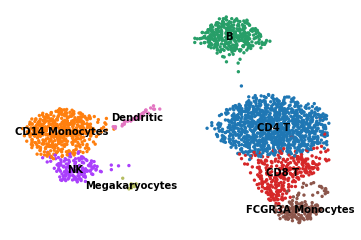

In [3]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


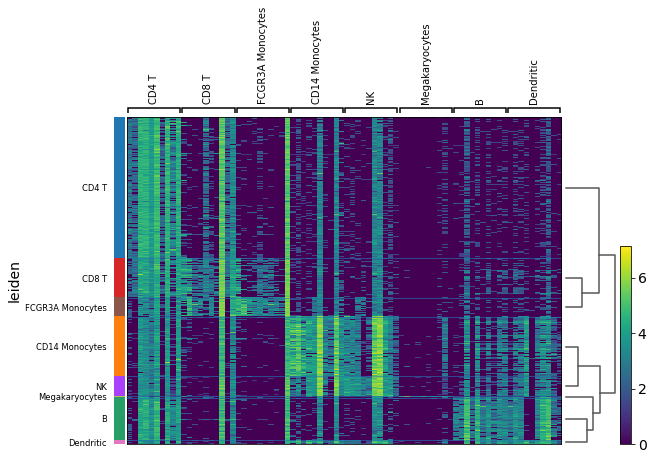

In [4]:
sc.tl.rank_genes_groups(adata, groupby='leiden')
sc.pl.rank_genes_groups_heatmap(adata, n_genes=10)

### Preprocessing: Import scanpy object into pyscnet 


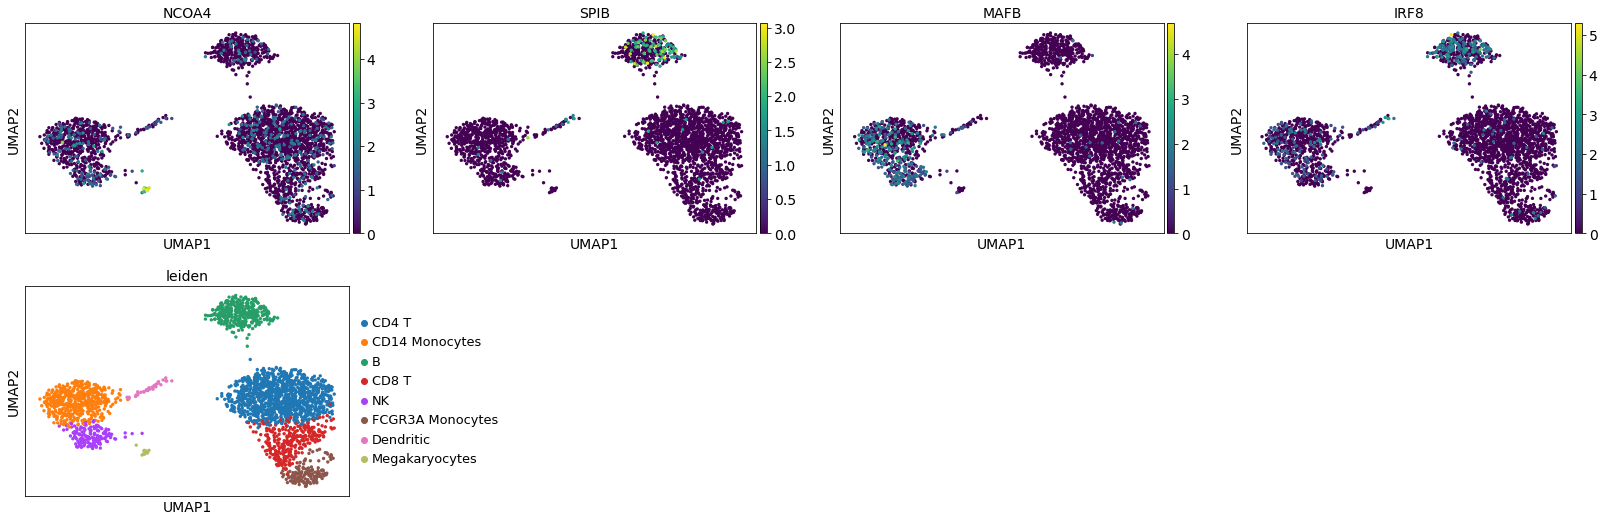

In [5]:
sc.pl.umap(adata, color=['NCOA4', 'SPIB', 'MAFB', 'IRF8', 'leiden'])

In [6]:
#import from local pickle
scanpy_gne = pp.load_from_anndata(adata)
scanpy_gne.info

Gnetdata object with 
ExpMatrix: 1838 x 2638
CellAttrs:dict_keys(['CellInfo'])
GeneAttrs:dict_keys(['GeneInfo'])
NetAttrs:dict_keys(['parameters'])


In [7]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

marker_genes = list(set(marker_genes) & set(scanpy_gne.ExpMatrix.index))
marker_genes

['CD79A',
 'FCGR3A',
 'KLRB1',
 'GNLY',
 'LGALS3',
 'S100A8',
 'MS4A1',
 'CST3',
 'NKG7',
 'FCER1A',
 'PPBP']

### Feature selection for each cell type
For each cell type, it is very important to pre-select features for creating gene regulatory network as there is less sense of including low expressed genes. To do so, top ranked markers genes of cell sub-population are selected for GRN construction. For instance, signatrues of CD8 t cells are used for CD8 T specific GRN.

In [8]:
Features = marker_genes
for cell in list(np.unique(adata.obs['leiden'])):
    Features += list(adata.uns['rank_genes_groups']['names'][cell])

Features = list(set(Features) & set(scanpy_gne.ExpMatrix.index))
len(Features)


207

In [9]:
Mms = pd.read_excel('/home/mwu/Downloads/supplementary_table_12_Ontogenet_Candidate_regulators.xls',header=1, skiprows=1)
list(set(Features) & set(Mms.Regulator))

['IRF8', 'ID2', 'CEBPB', 'TSC22D1', 'SPIB', 'MAFB', 'NCOA4']

### BuildNet: Construct GRN by applying popular methods 
As reported in [GRN benchmark paper](https://pubmed.ncbi.nlm.nih.gov/31907445/), although some tools were designed for estimating gene regulatory relationship from transcriptomic data, only three methods ([GENIE3](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0012776), [PIDC](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5624513/) and [GRNBOOST2](https://academic.oup.com/bioinformatics/article-abstract/35/12/2159/5184284?redirectedFrom=fulltext)) were considered as competitive. However, results generated from different algorithms based on different assumptions are inconsistent. Therefore, defining a consensus network from multiple network becomes essential for the downstream analysis.

In [ ]:

methods_list = ['phase_synchrony', 'GENIE3', 'PIDC', 'GRNBOOST2']

for cell in ['NK']:
    
    for method in methods_list:
        if method in ['window_rolling', 'phase_synchrony']:
            scanpy_gne = bn.get_synchrony(scanpy_gne.deepcopy, method=method,
                                          feature=Features, cell_clusterid=cell, select_by='leiden')
        else:
            scanpy_gne = bn.rundocker(scanpy_gne.deepcopy, method=method,
                                          feature=Features, cell_clusterid=cell, select_by='leiden', directed=False)

    scanpy_gne.save_as('/home/mwu/Desktop/pyscnet_scanpy_pbmc/'+ cell + '_gne.pk')

The GRN result is saved into **NetAttrs** as dataframes consisting *source*, *target* and *weight*. Top edges ordered by weight can be used for creating gene correlation graph.

### NetEnrich: Consensus edges and Build graph
pyscnet provides multiple ways of predicting consensus network: 

1) random forest classification; <br/>
2) network intersection; <br/>

Given consensus prediction, top *k* edges are selected for building gene graph. Genes importance can be estimated via node centralities including **degree, PageRank, closeness, betweenness**. Furthermore, gene modules are predicted by applying community detection algorithms.

In [11]:
names = ['B', 'CD14 Monocytes', 'CD4 T', 'CD8 T', 'Dendritic', 'FCGR3A Monocytes', 'NK']
for cell_name in names:
    
    scanpy_gne = pp.load_Gnetdata_object(filepath='/home/mwu/Desktop/pyscnet_scanpy_pbmc/' + cell_name + '_gne.pk')
    link_key=['GENIE3_links', 'PIDC_links', 'GRNBOOST2_links', 'phase_synchrony_links']

    #find consensus links based on ensemble classification
    scanpy_gne = ne.find_consensus_graph(scanpy_gne, method='intersection', toprank=5000, 
                                         link_key=link_key)

    #build graph for consensus links
    scanpy_gne = ne.buildnet(scanpy_gne, key_links='consensus_links')

    df = pd.DataFrame()


    for key in link_key:
        order_link = scanpy_gne.NetAttrs[key].sort_values('weight', ascending=False, ignore_index=True).head(5000)
        order_link['edge']= ["_".join(sorted([order_link.source[i], order_link.target[i]])) for i in range(order_link.shape[0])]
        order_link = order_link.drop_duplicates(subset=['edge'], keep='first')

        df[key] = order_link['edge']

    df.to_csv('/home/mwu/Desktop/pyscnet_scanpy_pbmc/' + cell_name + '_venn_df.csv', index=False)

    #For consensus graph, gene importance can be via node centrality
    scanpy_gne = ne.get_centrality(scanpy_gne)

    #gene module detected by louvain clustering
    scanpy_gne = ne.detect_community(scanpy_gne)

    tmp = scanpy_gne.NetAttrs['centralities']
    gap = len(Features) - tmp.shape[0]
    for name in tmp.columns[1:]:
        print(name)
        tmp[name + 'rank'] = tmp[name].rank() + gap

    tmp['avg_rank'] = tmp.iloc[:, 5:].mean(axis=1)
    tmp.to_excel('/home/mwu/Desktop/pyscnet_scanpy_pbmc/' + cell_name + '_centrality.xlsx', index=False)

there are 603 consensus edges found!
graph added into NetAttrs
node centralities added into NetAttrs.
gene communities added into NetAttrs
betweenness
closeness
degree
pageRank
there are 564 consensus edges found!
graph added into NetAttrs
node centralities added into NetAttrs.
gene communities added into NetAttrs
betweenness
closeness
degree
pageRank
there are 632 consensus edges found!
graph added into NetAttrs
node centralities added into NetAttrs.
gene communities added into NetAttrs
betweenness
closeness
degree
pageRank
there are 648 consensus edges found!
graph added into NetAttrs
node centralities added into NetAttrs.
gene communities added into NetAttrs
betweenness
closeness
degree
pageRank
there are 378 consensus edges found!
graph added into NetAttrs
node centralities added into NetAttrs.
gene communities added into NetAttrs
betweenness
closeness
degree
pageRank
there are 577 consensus edges found!
graph added into NetAttrs
node centralities added into NetAttrs.
gene communit

In [12]:
df = pd.read_excel('/home/mwu/Desktop/pyscnet_scanpy_pbmc/Marker_RankScore.xlsx')
df

,GeneName,B,CD4,CD8,CD14 Monocytes,Dendritic,FCGR3A Monocytes,NK
0,NCOA4,0.000,0.000,42.625,70.750,75.625,73.125,44.750
1,MAFB,196.125,180.000,196.625,118.000,176.625,97.125,28.500
2,IRF8,0.000,140.375,150.125,134.500,182.500,37.625,138.250
3,ID2,175.125,66.875,0.000,119.875,0.000,21.625,117.875
4,TSC22D1,49.125,78.625,113.000,116.750,169.500,0.000,91.500
5,SPIB,51.250,0.000,98.750,0.000,155.875,202.875,0.000
6,CEBPB,102.000,63.375,117.125,120.000,129.375,118.625,42.500


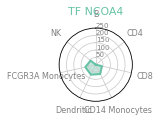

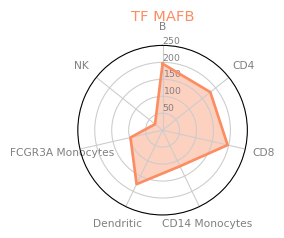

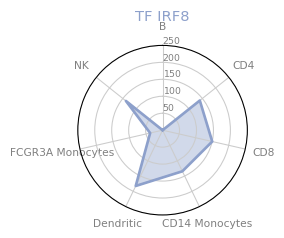

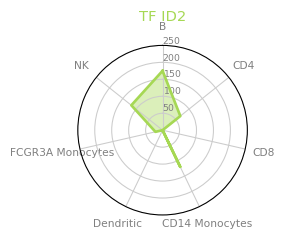

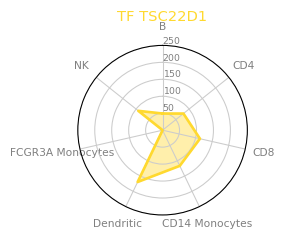

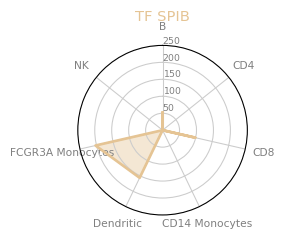

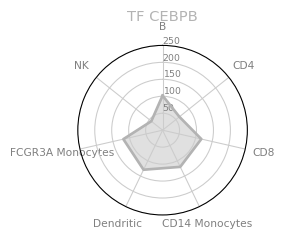

<Figure size 1000x1000 with 0 Axes>

In [22]:

import matplotlib.pyplot as plt
import pandas as pd
from math import pi
import random
 
def make_spider(row, title, color):
 
    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(2,4,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([50, 100, 150, 200, 250], ["50","100","150", '200', '250'], color="grey", size=7)
    plt.ylim(0,250)

    # Ind1
    values=df.loc[row].drop('GeneName').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)

    # ------- PART 2: Apply to all individuals
    # initialize the figure
    my_dpi=96
    plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))

# Loop to plot
for row in range(0, len(df.index)):
    make_spider( row=row, title='TF '+df['GeneName'][row], color=my_palette(row))

### NetEnrich: Graph travel and supervised random walk
NetEnrich module integretes graph traversal techniques to expolre gene regulatory network. It includes **Breadth-first search**, **Depth-first search** and **Supervised random walk**. In this way, gene trigger paths indicating genes with hidden associations can be predicted. 

In [ ]:
path = ne.graph_traveral(scanpy_gne.NetAttrs['graph'], start='CCL5', threshold=2, method='bfs')


In [ ]:
random_path = ne.self_guide_walk(scanpy_gne, start='CCL5', supervisedby='pageRank', steps=5)
random_path

### Plotting: Network Visualization 

In [ ]:
pl.dynamic_netShow(scanpy_gne, filename='/home/mwu/Desktop/test.html')

In [ ]:
from pyscnet.Plotting import net_plot as npl
import matplotlib.pyplot as plt 
plt.switch_backend("cairo")
fig, ax = plt.subplots(1, 2, figsize=(40, 18))
# npl.net_matrix_plot(stream_gne, output_size=(500, 500), vertex_text_position=-2, vertex_font_size=5)
pl.net_hierarchy_plot(scanpy_gne, vertex_text_position=-2, vertex_size=0.2,  vertex_font_size=0.05, mplfig=ax[0])
pl.net_matrix_plot(scanpy_gne, vertex_text_position=-2, vertex_size=0.8,  vertex_font_size=0.2, mplfig=ax[1])
ax[0].axis('off')
ax[1].axis('off')

In [ ]:
corr_gene = ['GZMA', 'GZMK', 'LYAR']
pl.geneCorrelation(scanpy_gne, gene=corr_gene,
                cell_clusterid=('CD8 T'), select_by='leiden', order_by='total_counts',
                xticklabels=True, yticklabels=True,
                figsize=[5, 4], vmax=0.5, vmin=-0.5, annot=True)

In [ ]:

cg = pl.geneHeatmap(scanpy_gne, gene=corr_gene,figsize=[10,1.5], 
                    cell_clusterid=('CD8 T'), select_by='leiden', order_by='total_counts', 
                    yticklabels=True,
                    col_cluster=False, cmap='RdBu_r')

cg.ax_row_dendrogram.set_visible(False)

In [ ]:
new_app = pl.create_app(gnetdata=scanpy_gne, grn_method='consensus_links', top_links=122, resolution=0.6)
new_app

In [ ]:
 #save pyscnet as pickle
# scanpy_gne.save_as('tutorial_data/pyscnet_scanpy.pk')
scanpy_gne = pp.load_Gnetdata_object('/home/mwu/Desktop/CD8_gne.pk')

In [ ]:
import matplotlib.lines as mlines

X_Score = pd.read_excel('/home/mwu/Desktop/B_centrality.xlsx').sort_values('node', ignore_index=True)
Y_Score = pd.read_excel('/home/mwu/Desktop/CD8_centrality.xlsx').sort_values('node', ignore_index=True)

fig = plt.figure(figsize=(20,12))

plt.scatter(X_Score.avg_rank, Y_Score.avg_rank, alpha=0.8)
plt.plot(np.arange(0, 103), np.arange(0, 103), 'r--')

plt.xlabel('B_rank_score')
plt.ylabel('CD8_rank_score')

plt.grid(None)

for i in range(len(X_Score.node)):
    
    plt.annotate(X_Score.node[i], 
                 (X_Score.avg_rank[i], Y_Score.avg_rank[i]),
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center') 

plt.savefig('/home/mwu/Desktop/B_Vs_Cd8_plot.pdf')



In [ ]:
Y_Score.head()